In [49]:
import pandas as pd
import numpy as np
import pickle
from nltk.corpus import wordnet, stopwords
# from nltk.tokenize import TweetTokenizer
from pattern.en import lemma,singularize
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import math
from Levenshtein import ratio

In [2]:
from pattern.en import lemma
def Tokenizer(word):
    def get_rid_of_apostrophe(s):
        if s[-3:] == "in'":
            s = s[:-3] + "ing"
        if s[-2:] == "'s" or s[-2:] == "''":
            s = s[:-2]
        if s[-1:] == "'":
            s = s[:-1]
        return s
    temp = lemma(get_rid_of_apostrophe(word))
    while lemma(get_rid_of_apostrophe(temp)) != temp:
        temp = lemma(get_rid_of_apostrophe(temp))
    return temp

In [3]:
# data = pickle.loads(open("../data/pickle/all_lyric_data_filtered_dict.pickle", "rb").read())

In [34]:
df = pd.DataFrame(data.keys())
df.columns = ["song", "artist"]
for i in ["genius", "az_lyrics", "lyrics_az"]:
    for j in ["raw", "bag"]:
        df["{}_{}".format(i, j)] = None

In [139]:
# for i in range(df.shape[0]):
#     s, a = df.loc[i, ["song", "artist"]]
#     for j in ["genius", "az_lyrics", "lyrics_az"]:
#         if data[(s, a)][j] != None:
#             df.loc[i, ["{}_raw".format(j), "{}_bag".format(j)]] = data[(s, a)][j][0], [Tokenizer(i) for i in data[(s, a)][j][1]]
#     if i % 5000 == 0:
#         print(i）
# pickle.dump(df, open("df_concat.pickle", "wb"))

### Get Levenshtein ratio accross dataset

In [53]:
df["GvAZL"] = [ratio(" ".join(g), " ".join(azl)) if g != None and azl != None else 0 for g, azl in df[["genius_bag", "az_lyrics_bag"]].values.tolist() ]
df["GvLAZ"] = [ratio(" ".join(g), " ".join(laz)) if g != None and laz != None else 0 for g, laz in df[["genius_bag", "lyrics_az_bag"]].values.tolist()]
df["AZLvLAZ"] = [ratio(" ".join(azl), " ".join(laz)) if laz != None and azl != None else 0 for azl, laz in df[["az_lyrics_bag", "lyrics_az_bag"]].values.tolist()]

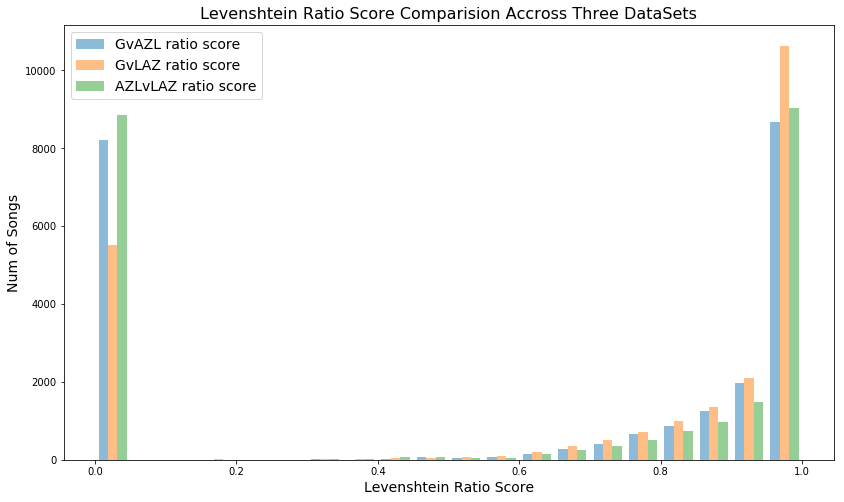

In [106]:
plt.figure(figsize=(13.8, 8))
# for i in ["GvAZL", "GvLAZ", "AZLvLAZ"]:
#     plt.plot(list(range(df.shape[0])), sorted(df[i]), label="{} ratio score".format(i))
plt.hist([df[i] for i in ["GvAZL", "GvLAZ", "AZLvLAZ"]], label=["{} ratio score".format(i) for i in ["GvAZL", "GvLAZ", "AZLvLAZ"]], 
         alpha=0.5, bins=20)
plt.xlabel("Levenshtein Ratio Score", fontsize=14)
plt.ylabel("Num of Songs", fontsize=14)
plt.title("Levenshtein Ratio Score Comparision Accross Three DataSets", fontsize=16)
plt.legend(fontsize=14)
plt.show()

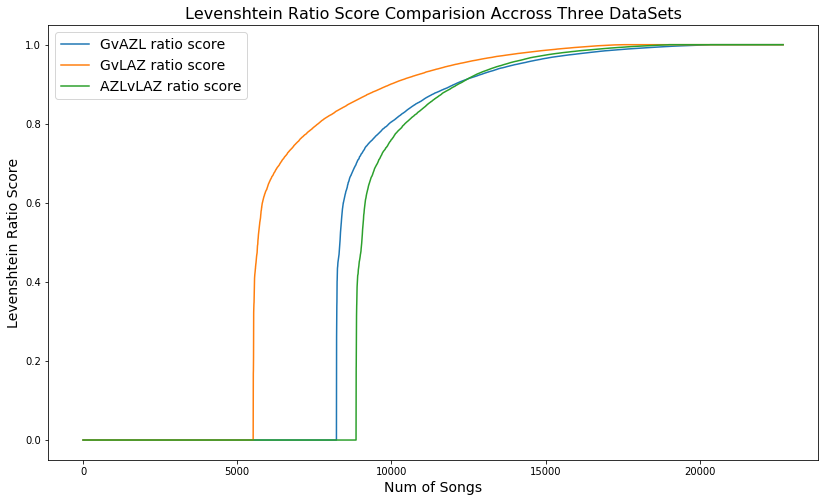

In [105]:
plt.figure(figsize=(13.8, 8))
for i in ["GvAZL", "GvLAZ", "AZLvLAZ"]:
    plt.plot(list(range(df.shape[0])), sorted(df[i]), label="{} ratio score".format(i))
plt.xlabel("Num of Songs", fontsize=14)
plt.ylabel("Levenshtein Ratio Score", fontsize=14)
plt.title("Levenshtein Ratio Score Comparision Accross Three DataSets", fontsize=16)
plt.legend(fontsize=14)
plt.show()

### Construct Bag Of Words (Take the Intersection)

In [74]:
df["genius_counter"] = [Counter(i) for i in df["genius_bag"]]
df["az_lyrics_counter"] = [Counter(i) for i in df["az_lyrics_bag"]]
df["lyrics_az_counter"] = [Counter(i) for i in df["lyrics_az_bag"]]

In [120]:
df["word_intersect"] = None
try:
    for i in range(df.shape[0]):
        bags = [set(j.keys()) for j in df.loc[i, ["genius_counter", "az_lyrics_counter", "lyrics_az_counter"]] if len(j) != 0]
        if len(bags) == 0:
            df.loc[i, "word_intersect"] = ""
        else:
            intersection = bags[0]
            for bag in bags[1:]:
                intersection = intersection.intersection(bag)
            df.loc[i, "word_intersect"] = " ".join(list(intersection))
        if i%5000 == 0:
            print(i)
except Exception as Error:
    print(i)
    print(Error)

0
5000
10000
15000
20000


In [128]:
words_song_count = Counter([j for i in df["word_intersect"] for j in i.split(" ")])
print("Num of Unique words (before removing stopWords): ", len(words_song_count))

Num of Unique words (before removing stopWords):  39471


In [129]:
words_song_count.most_common(10)

[('the', 21167),
 ('be', 20719),
 ('to', 20687),
 ('and', 20547),
 ('i', 20283),
 ('you', 20211),
 ('a', 19697),
 ('it', 18246),
 ('me', 18147),
 ('in', 17212)]

In [133]:
stopWords = set(stopwords.words("english"))
words_song_count_rm = Counter({i: words_song_count[i] for i in list(set(words_song_count.keys()) - set(stopwords.words("english")))})
words_song_count_rm = Counter({i: words_song_count[i] for i in list(set(words_song_count_rm.keys()) - set([lemma(i) for i in stopwords.words("english")]))})
for i in [j for j in words_song_count_rm.keys() if len(j) == 1]:
    words_song_count_rm.pop(i)
print("Num of Unique words (after removing stopWords): ", len(words_song_count_rm))

Num of Unique words (after removing stopWords):  39300


In [134]:
words_song_count_rm.most_common(10)

[('know', 14301),
 ('get', 13579),
 ('love', 12972),
 ("i'm", 12559),
 ('go', 12128),
 ('like', 11049),
 ('say', 10897),
 ('make', 10424),
 ('come', 10025),
 ('see', 9824)]

In [135]:
bag_of_words_intersect = list(words_song_count_rm.keys())

In [137]:
print("Genius # Uniq Words:  ", len(Counter([j for i in df["genius_counter"] for j in i.keys()])))
print("az_lyrics # Uniq Words:  ", len(Counter([j for i in df["az_lyrics_counter"] for j in i.keys()])))
print("lyrics_az # Uniq Words:  ", len(Counter([j for i in df["lyrics_az_counter"] for j in i.keys()])))
print("Intersection # words (after removing stopWords): ", len(words_song_count_rm))

Genius # Uniq Words:   45285
az_lyrics # Uniq Words:   41197
lyrics_az # Uniq Words:   45917
Intersection # words (after removing stopWords):  39300


In [101]:
verify = set([j for i in df["genius_counter"] for j in i.keys()]).intersection([j for i in df["az_lyrics_counter"] for j in i.keys()]).intersection([j for i in df["lyrics_az_counter"] for j in i.keys()])

In [138]:
df.head()

,song,artist,genius_raw,genius_bag,az_lyrics_raw,az_lyrics_bag,lyrics_az_raw,lyrics_az_bag,GvAZL,GvLAZ,AZLvLAZ,genius_counter,az_lyrics_counter,lyrics_az_counter,word_intersect
0,sauce it up,lil uzi vert,"[Intro]\nSauce it up, ayy, sauce it up, ayy\nS...","[sauce, it, up, ayy, sauce, it, up, ayy, sauce...","Sauce it up, ayy, sauce it up, ayy<br>\nSauce ...","[sauce, it, up, ayy, sauce, it, up, ayy, sauce...",[Intro]<br />\nSauce it up (aye)<br />\nSauce ...,"[sauce, it, up, aye, sauce, it, up, aye, sauce...",0.981573,0.852666,0.864487,"{'sauce': 18, 'it': 32, 'up': 36, 'ayy': 7, 'g...","{'sauce': 18, 'it': 32, 'up': 36, 'ayy': 7, 'i...","{'sauce': 12, 'it': 28, 'up': 24, 'aye': 6, 'g...",let okay say on harley brrr woo cardi greatest...
1,backroad song,granger smith,Barbed wire fence carving out a hillside\nCutt...,"[barb, wire, fence, carve, out, a, hillside, c...","Barbed wire fence carving out a hillside, cutt...","[barb, wire, fence, carve, out, a, hillside, c...","Barbed wire fence carving out a hillside, cutt...","[barb, wire, fence, carve, out, a, hillside, c...",0.996372,0.997579,0.998789,"{'barb': 1, 'wire': 1, 'fence': 1, 'carve': 1,...","{'barb': 1, 'wire': 1, 'fence': 1, 'carve': 1,...","{'barb': 1, 'wire': 1, 'fence': 1, 'carve': 1,...",let feel we're today grey on song hear ooh-ooh...
2,feelin' satisfied,boston,[Verse 1]\nWell come on\nAll you people\nThe t...,"[well, come, on, all, you, people, the, time, ...",Well come on<br>\nAll you people<br>\nThe time...,"[well, come, on, all, you, people, the, time, ...",Well come on<br />\nAll you people<br />\nThe ...,"[well, come, on, all, you, people, the, time, ...",0.949709,0.946203,0.996477,"{'well': 2, 'come': 9, 'on': 9, 'all': 1, 'you...","{'well': 2, 'come': 10, 'on': 11, 'all': 1, 'y...","{'well': 2, 'come': 10, 'on': 11, 'all': 1, 'y...",people let can alright satisfy feel give win o...
3,saturday morning confusion,bobby russell,"Here they come, warming up\nI hear the pitter ...","[here, they, come, warm, up, i, hear, the, pit...",None,None,"Here they come, warming up<br />\nI hear the p...","[here, they, come, warm, up, i, hear, the, pit...",0.000000,0.999033,0.000000,"{'here': 3, 'they': 3, 'come': 3, 'warm': 2, '...",{},"{'here': 3, 'they': 3, 'come': 3, 'warm': 2, '...",let feel dog today how hear on come rude we'll...
4,country man,luke bryan,"[Verse 1]\nYou need hands, rough not soft\nTo ...","[you, need, hand, rough, not, soft, to, come, ...","You need hands, rough not soft<br>\nTo come an...","[you, need, hand, rough, not, soft, to, come, ...","You need hands, rough not soft<br />\nTo come ...","[you, need, hand, rough, not, soft, to, come, ...",0.971121,0.967205,0.991220,"{'you': 7, 'need': 1, 'hand': 2, 'rough': 1, '...","{'you': 7, 'need': 1, 'hand': 2, 'rough': 1, '...","{'you': 7, 'need': 1, 'hand': 2, 'rough': 1, '...",let gator tenni move come way muscle tree thes...
